# Mutual Information, Similarity, and Influence

In this notebook, I perform clustering analysis on the voting records of the senators and develop the influence scores.  

For each of 100 senators, we have a corresponding array which represents their voting behavior over the 502 roll call votes. 

The arrays look something like $ Schumer = [0, 1, 1, 0, ...]$. In order to perform clustering analysis, we need to have a distance matrix which contains the distances between all of the vectors. The distance metric we will use is a metricized version of mutual information. 

This design decision follows from the model of voting behavior and our academic motivation to answer the following question: 

 > For two senators Alica and Bob, how much uncertainty in Bob's vote is eliminated given knowledge of Alice's vote?
 
Mutual information can help to answer this question. 

Mutual information itself is not a [metric](https://en.wikipedia.org/wiki/Metric_(mathematics), because it does not satisfy the properties of non-negativity and symmetry, and it does not obey the triangle inequality. We can, however, create a metricized version of mutual information to use for clustering.

Entropy is a measure of the unpredictability of the state. Entropy is represented as 

$$ \large{ H(X) =  - \sum_{i=1}^{n} P(x_i) log_b P(x_i)} $$

![entropy](../gallery/influence_predictions/Binary_entropy_plot.png)

If A and B are two arrays representing the votes of Senators Alice and Bob, we know that the entropy is non-negative because the values in A and B are discrete. We therefore can create a normalized distance $ \bf {D(A, B)} $

$$ \large {D(A, B) = 1 - \frac {I(X;Y)}{H(X,Y)}} $$


Where $ \bf {H(X,Y)} $ is the [joint entropy](https://en.wikipedia.org/wiki/Joint_entropy) of two discrete random variables.

And where $ \bf  {I(X;Y)} $ is the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) given by

$$ \large { I(X;Y) = H(X) + H(Y) - H(X,Y)} $$


In [129]:
# calculate mutual information for all of the senators in the dataset and with the outcome

import pandas as pd
import numpy as np

# clustering
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import pdist # will calcualte a distance matrix given a supplied defined distance metric
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet # will allow for custom clustering based on our distance metric
np.set_printoptions(precision=5, suppress=True) # truncate printed floats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# show images inline
from IPython.display import Image

In [130]:
votes = pd.read_csv('../data/cleaned_votes.csv', index_col=0)
senators = votes.iloc[:, :-1].columns.tolist()
vals = votes.iloc[:, :-1].values.T

## Mutual Information Metric (Effectively Jaccard Distance)

In [131]:
# calculate the mutual information

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# calculate entropy
def entropy(X, Y):
    probs = []
    for c1 in set(X):
        for c2 in set(Y):
            probs.append(np.mean(np.logical_and(X == c1, Y == c2)))

    return np.sum(-p * np.log2(p) for p in probs if p > 0)

def r_dist(x,y):
    return (1 - ((calc_MI(x,y,100))/entropy(x,y)))

In [132]:
# our distance matrix
dm = pdist(vals, r_dist)

Z = linkage(vals, metric=r_dist)

c, coph = cophenet(Z, dm)
print (c)

0.95436302082


In [133]:
Z[:10]

array([[  12.     ,   67.     ,    0.42671,    2.     ],
       [  25.     ,   75.     ,    0.47155,    2.     ],
       [  44.     ,   73.     ,    0.49657,    2.     ],
       [  71.     ,   87.     ,    0.50145,    2.     ],
       [  82.     ,  102.     ,    0.52206,    3.     ],
       [   2.     ,   35.     ,    0.52464,    2.     ],
       [  37.     ,  104.     ,    0.53394,    4.     ],
       [  96.     ,  106.     ,    0.5371 ,    5.     ],
       [  14.     ,  107.     ,    0.54092,    6.     ],
       [  10.     ,  105.     ,    0.54517,    3.     ]])

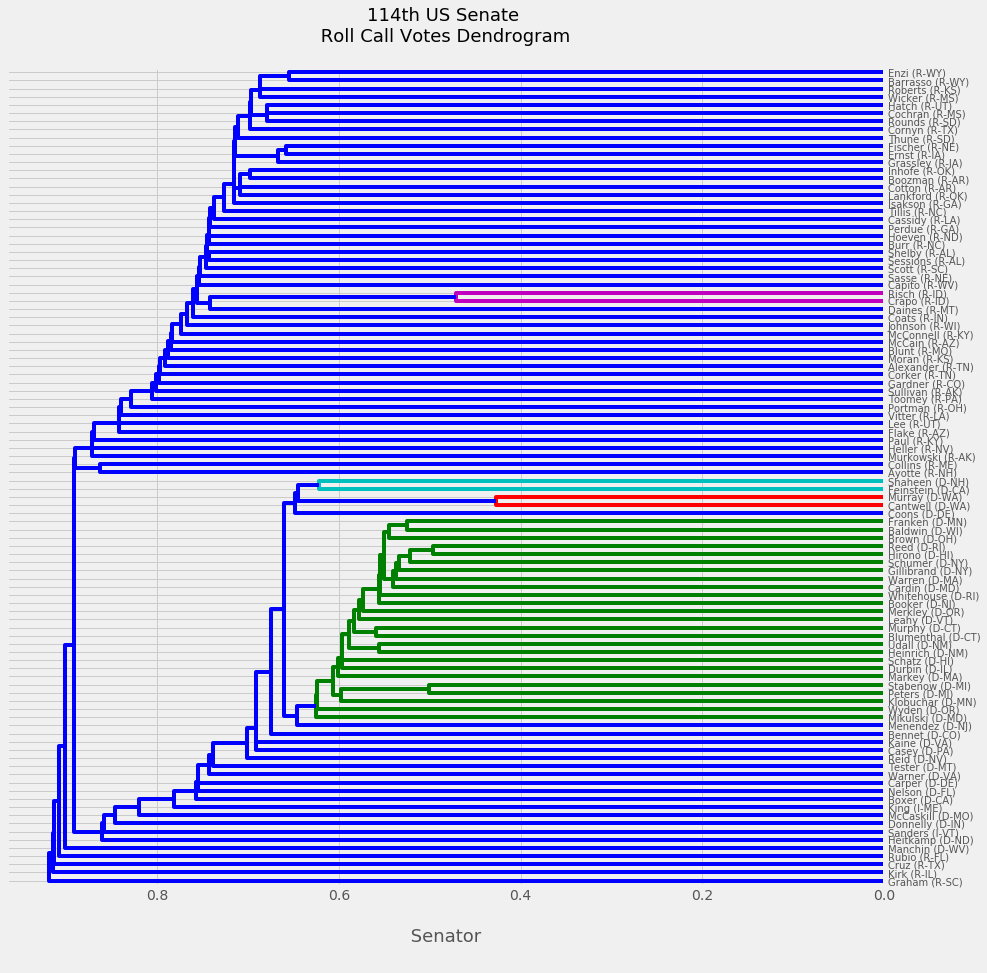

In [136]:
# calculate full dendrogram
plt.figure(figsize=(14, 14))
plt.title('114th US Senate \n Roll Call Votes Dendrogram \n', fontsize=18)
plt.xlabel('\n Senator \n ', fontsize=18)
plt.ylabel('')

dend = dendrogram(
    Z,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    orientation='left',
    labels=senators,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=700,  # show only the last p merged clusters
    show_contracted=True,  
    
)
plt.savefig('../gallery/cluster_correlation/dendrogram.png')
plt.show()

In [135]:
dend['color_list'][:3]

['g', 'g', 'g']

### Calculate mutual information between Senator and outcome

In [138]:
outcome_information = {} # create dict to store the values
outcomes = votes.iloc[:, -1:].values.reshape(438,)
for i, senator in enumerate(senators):
    outcome_information[senator] = calc_MI(vals[i], outcomes, 2)
otcs = pd.Series(outcome_information)
otcs = otcs.sort_values(ascending=False)

In [139]:
otcs[:20]

Cochran (R-MS)      0.165132
McConnell (R-KY)    0.163380
Alexander (R-TN)    0.155987
Hatch (R-UT)        0.146168
Capito (R-WV)       0.140117
Rounds (R-SD)       0.127858
Ayotte (R-NH)       0.114744
Isakson (R-GA)      0.105607
Cornyn (R-TX)       0.105307
Burr (R-NC)         0.105040
Tillis (R-NC)       0.104806
Collins (R-ME)      0.101992
Wicker (R-MS)       0.097869
Murkowski (R-AK)    0.097692
McCain (R-AZ)       0.093504
Kirk (R-IL)         0.093504
Johnson (R-WI)      0.092061
Gardner (R-CO)      0.091563
Hoeven (R-ND)       0.090228
Heitkamp (D-ND)     0.085496
dtype: float64

Republicans were clearly very influential on the outcome of the vote in the 114th US Senate. 

### Influence by Senator

In [140]:
from sklearn.externals import joblib
joblib.dump(otcs, '../data/senators_by_influence.pkl')

['../data/senators_by_influence.pkl']

In [141]:
otcs[:20]

Cochran (R-MS)      0.165132
McConnell (R-KY)    0.163380
Alexander (R-TN)    0.155987
Hatch (R-UT)        0.146168
Capito (R-WV)       0.140117
Rounds (R-SD)       0.127858
Ayotte (R-NH)       0.114744
Isakson (R-GA)      0.105607
Cornyn (R-TX)       0.105307
Burr (R-NC)         0.105040
Tillis (R-NC)       0.104806
Collins (R-ME)      0.101992
Wicker (R-MS)       0.097869
Murkowski (R-AK)    0.097692
McCain (R-AZ)       0.093504
Kirk (R-IL)         0.093504
Johnson (R-WI)      0.092061
Gardner (R-CO)      0.091563
Hoeven (R-ND)       0.090228
Heitkamp (D-ND)     0.085496
dtype: float64

### Influence by State

In [142]:
votes.head()

,Alexander (R-TN),Ayotte (R-NH),Baldwin (D-WI),Barrasso (R-WY),Bennet (D-CO),Blumenthal (D-CT),Blunt (R-MO),Booker (D-NJ),Boozman (R-AR),Boxer (D-CA),...,Tillis (R-NC),Toomey (R-PA),Udall (D-NM),Vitter (R-LA),Warner (D-VA),Warren (D-MA),Whitehouse (D-RI),Wicker (R-MS),Wyden (D-OR),outcome
1,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,1,1,1,0,1,0
2,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
3,1,1,0,1,1,0,1,0,1,0,...,1,1,1,1,1,0,0,1,0,1
4,1,1,0,1,0,0,1,0,1,0,...,1,1,0,1,1,0,0,1,0,1
5,1,1,0,1,0,0,1,0,1,0,...,1,1,0,1,0,0,0,1,0,1


In [143]:
# first need to create a set of all the states

state_list = {}
for senator in votes.columns[0:-1]:
    #get the state
    state = str(senator)[-3:-1]

    #check if the state is already in the dict
    
    if state in list(state_list.keys()):

        state_list[state].append(senator) # if true, add the other senator
        
    else: #create a new entry
        state_list[state] = [senator]

In [144]:
# get the voting record for each senator in each state
state_records = {}
for key, value in state_list.items():
    state_records[key] =[votes[value[0]].values, votes[value[1]].values]

In [145]:
# state cohesiveness, which states are the most similar in terms of voting records? 
state_similarity = {}

for key, value in state_records.items():
    state_similarity[key] = calc_MI(value[0], value[1], bins=100)

In [146]:
# create series with state cohesiveness

cohesion = pd.Series(state_similarity)
cohesion.name = 'cohesion'

# most values are close together, let's compute the % differnece from the average and make a new series

average = cohesion.values.mean()
new_scores = pd.Series((((cohesion.values - average)) / average) * 100 )
new_scores.index = cohesion.index
new_scores_sorted = new_scores.sort_values(ascending=False)

In [147]:
cohesion.describe()

count    5.000000e+01
mean     2.619830e-01
std      1.968796e-01
min      5.035151e-09
25%      5.627740e-02
50%      3.003123e-01
75%      4.198521e-01
max      5.901580e-01
Name: cohesion, dtype: float64

In [148]:
# create a color map
color_dict = {}
for state, score in zip(new_scores_sorted.index.values, new_scores_sorted.values):
    if score >= 0: color_dict[state] = 'green'
    else: color_dict[state] = 'red'

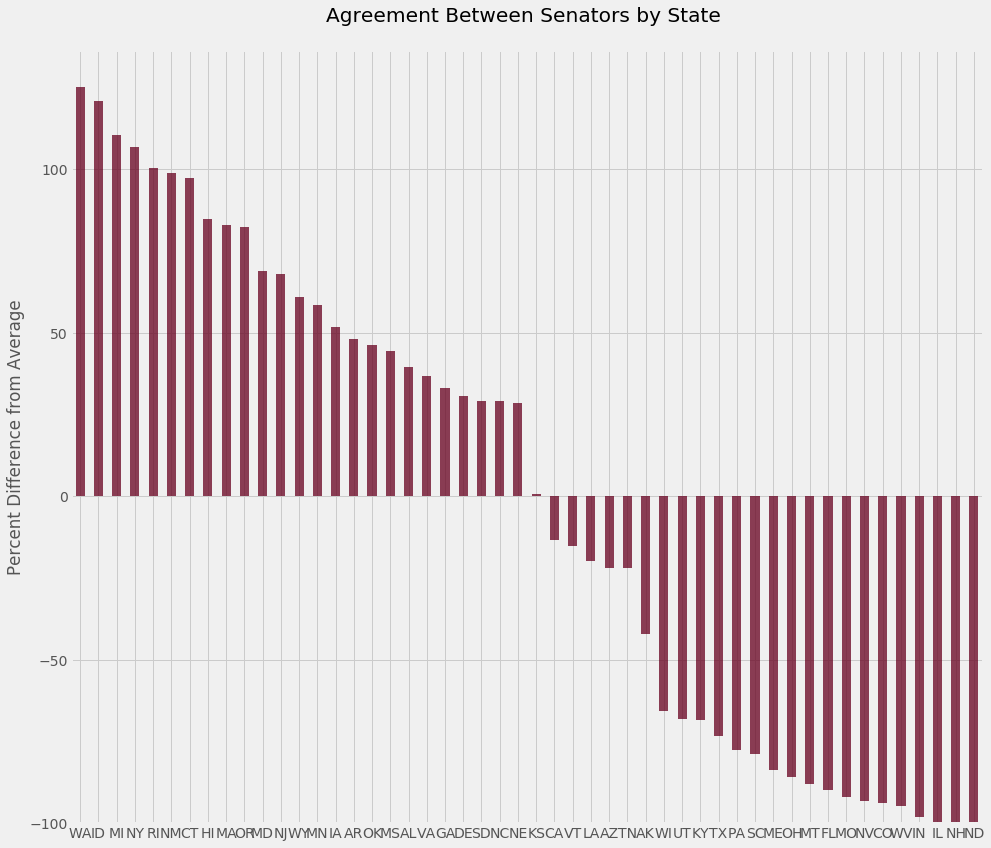

In [149]:
plt.figure(figsize=(14,12))
new_scores_sorted.plot(kind='bar', colormap='RdBu', alpha=.75)
plt.xticks(rotation=0)
plt.title('Agreement Between Senators by State \n')
plt.ylabel('Percent Difference from Average')

plt.tight_layout(w_pad=.5)
plt.savefig('../gallery/influence_predictions/prelim_state_agreement.png')
plt.show()


In [150]:
# save these for later, do more viz in another notebook with Bokeh
from sklearn.externals import joblib
joblib.dump(new_scores_sorted, '../data/state_agreement_scores.pkl')
joblib.dump(color_dict, '../data/temp_color_dict.pkl')

['../data/temp_color_dict.pkl']

There are a 8 possible outcomes when senators A and B vote on a bill: 

They disagree and the bill passes (e.g. outcome == 1):
    - A votes 1, B votes 0, Outcome is 1
    - A votes 0, B votes 1, Outcome is 1
They disagree and the bill is rejected (e.g. outcome == 0):
    - A votes 1, B votes 0, Outcome is 0
    - A votes 0, B votes 1, Outcome is 0
They agree and the bill passes (e.g. outcome == 1):
    - A and B vote 1, Outcome is 1
    - A and B vote 0, Outcome is 1
They agree and the bill is rejected (e.g. outcome == 0)::
    - A and B vote 1, Outcome is 0
    - A and B vote 0, Outcome is 0


In [151]:
def categorize_records(arr1, arr2):
    categorized = []
    for i, j in zip(arr1, arr2):
        if (i == 0) & (i==j):
            categorized.append(0)
        elif (i == 1) & (i==j):
            categorized.append(1)
        elif (i == 1) & (j==0):
            categorized.append(2)
        elif (i == 0) & (j==1):
            categorized.append(2)
        else: categorized.append(999)
    return categorized

In [152]:
# get the voting record of the two senators and label 
transformed_dict = {}
for key, value in state_records.items():
    transformed_dict[key] = categorize_records(value[0], value[1])

In [153]:
# let's calculate mutual information between state and senate
states_records = pd.Series(transformed_dict) # convert to series for ease of use
mutual_info_state_outcome = {} # create a dict to save the information
otc = votes.outcome.values # fetch the outcomes
for state, record in zip(states_records.index.values, states_records.values):
    mutual_info_state_outcome[state] = calc_MI(otc, record, 2)

mutual_info_state_outcome = pd.Series(mutual_info_state_outcome)

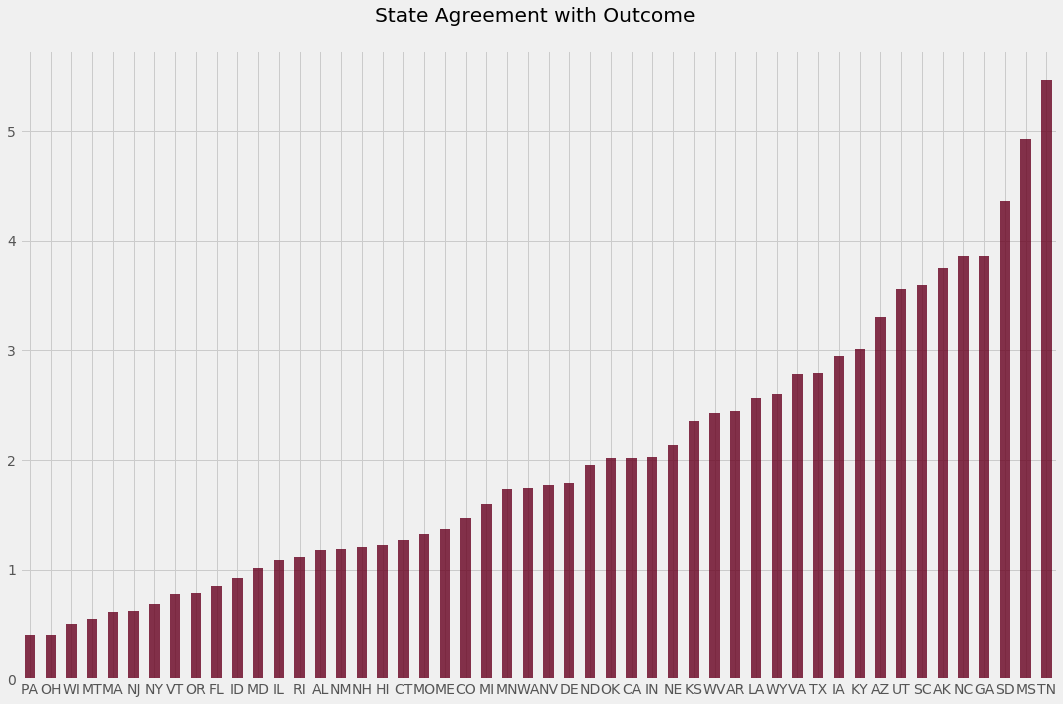

In [156]:
plt.figure(figsize=(15,10))
((mutual_info_state_outcome / sum(mutual_info_state_outcome))*100).sort_values().plot(kind='bar',  colormap='RdBu',alpha=.8)
plt.xticks(rotation=0)
plt.title('State Agreement with Outcome \n')
plt.tight_layout()
plt.savefig('../gallery/influence_predictions/state_outcome_scores_temp.png')
plt.show()

## Parties Influence

In [6]:
# make a list of parties

reps = []
dems = []
ind = []

for name in senators:
    party = name[-5:-4]
    if party == 'D':
        dems.append(name)
    elif party == 'R':
        reps.append(name)
    else:
        ind.append(name)

In [8]:
parties=[]
for name in senators:
    parties.append(name[-5:-4])

In [24]:
target = pd.Series(parties).map({'D': 0, 'R': 1, 'I': 2})
target.name = 'Party'
target.index = votes.iloc[:, :-1].T.index

In [34]:
partied = votes.T.join(target)

In [36]:
partied.iloc[:, :-1].head()

,1,2,3,4,5,6,7,8,9,10,...,462,478,487,492,494,496,497,500,501,502
Alexander (R-TN),0,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
Ayotte (R-NH),0,1,1,1,1,1,1,0,0,1,...,1,0,1,0,1,1,1,1,1,1
Baldwin (D-WI),1,1,0,0,0,1,0,1,0,1,...,1,1,1,0,1,1,1,1,0,1
Barrasso (R-WY),0,1,1,1,1,1,1,0,1,1,...,1,0,1,1,1,1,1,1,1,1
Bennet (D-CO),0,1,1,0,0,1,0,1,0,1,...,1,1,1,0,1,1,1,1,1,1


In [8]:
from math import log2
import numpy as np

In [29]:
a=np.random.randint(0, 2, 100)

In [35]:
prob1 = a.mean()
prob0 = 1-prob1

In [36]:
ent = 0
for val in a:
    if val == 0:
        ent += (-1 * prob0 * log2(prob0))
    else: 
        ent += (-1 * prob1 * log2(prob1))
        

In [39]:
ent

49.163139452829512

In [59]:
probs = np.linspace(0.000001, 1.00001, 1000)

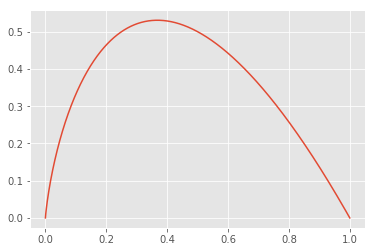

In [61]:
plt.plot(probs, vals)
plt.show()

In [98]:
from scipy.stats import entropy as en

In [89]:
a1 = np.random.randint(0,2, 100)
b1 = np.random.randint(0,2, 100)

In [93]:
entropy(a1, b1)

1.9837068202000796

In [102]:
en(a1, b1)

inf